In [31]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import subplots, cm
from sklearn.metrics import RocCurveDisplay
import sklearn.model_selection as skm
from sklearn.svm import SVC
from ISLP import load_data, confusion_table
from ISLP.svm import plot as plot_svm


In [5]:
roc_curve = RocCurveDisplay.from_estimator

## 9.6 Lab: Support Vector Machines

In this lab, we use the `sklearn.svm` library to demonstrate the support vector classifer and the support vector machine.

### 9.6.1 Support Vector Classifier

We fit the support vector classifier for a given value of parameter `C`, the cost of a violation to the margin. Where `C` is small, the margins will be wide and many support vectors will be on or violate the margin. Where `C` is lage, the margins will be narrow and there will be few support vectors on or violating the margin.

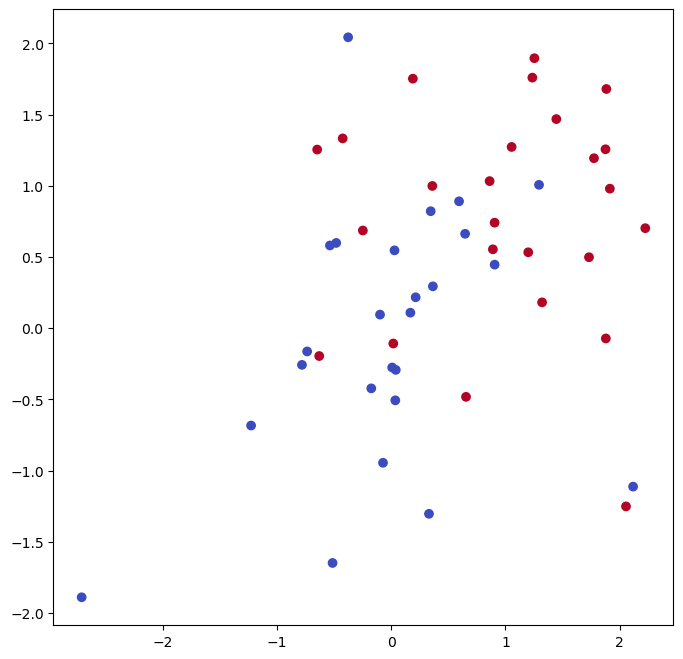

In [11]:
rng = np.random.default_rng(1)
X = rng.standard_normal((50, 2))
y = np.array([-1]*25+[1]*25)
X[y==1] += 1
fig, ax = subplots(figsize=(8,8))
ax.scatter(
    X[:,0],
    X[:,1],
    c=y,
    cmap=cm.coolwarm
);

Note that the two classes in this randomly generated data are not linearly separable. 

We now fit the classifier:

In [27]:
svm_linear = SVC(C=10, kernel='linear')
svm_linear.fit(X, y)

SVC(C=10, kernel='linear')

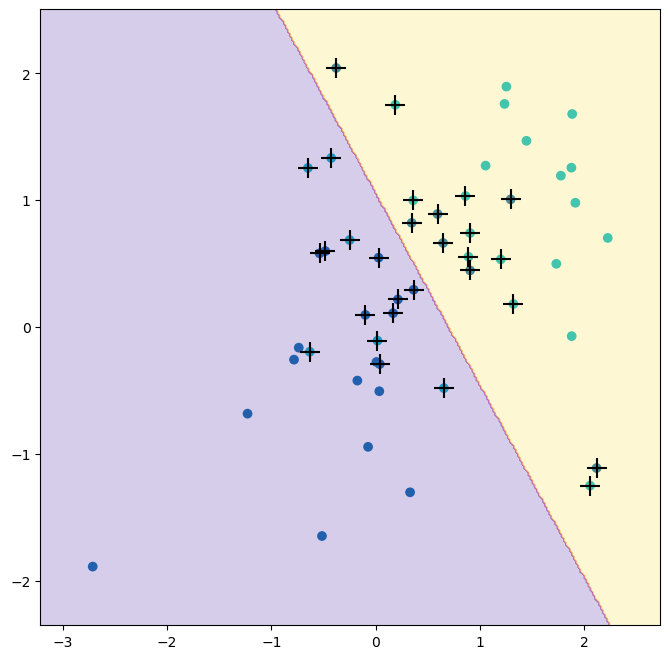

In [33]:
fig, ax = subplots(figsize=(8, 8))
plot_svm(X, y, svm_linear, ax=ax)

What is we use a smaller cost parameter (`C` value)?

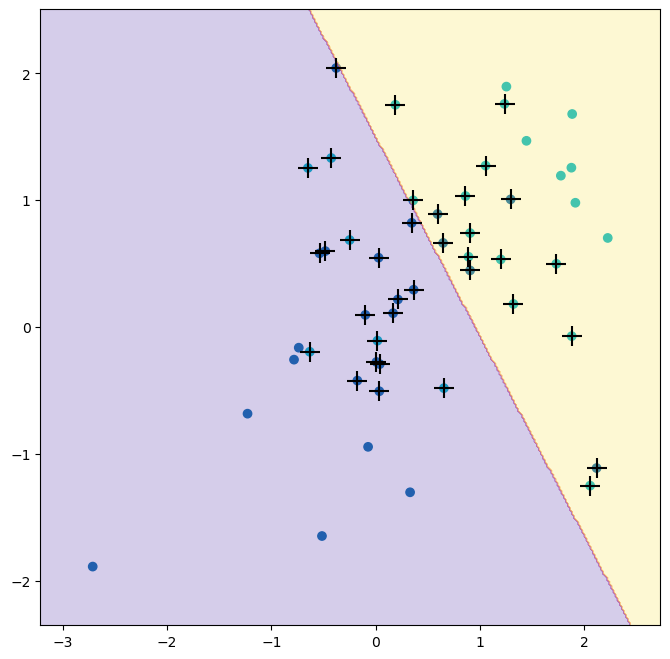

In [29]:
svm_linear_small = SVC(C=0.1, kernel='linear')
svm_linear_small.fit(X, y)
fig, ax = subplots(figsize=(8, 8))
plot_svm(
    X,
    y,
    svm_linear_small,
    ax=ax
)

With a smaller value of the cost parameter, we obtain a larger number of support vectors because the margin is wider.

Since the SVM is an estimator in `sklearn`, we can tune it:

In [34]:
kfold = skm.KFold(
    5,
    random_state=0,
    shuffle=True
)

grid = skm.GridSearchCV(
    svm_linear,
    {'C': [0.001, 0.01, 0.1, 0.1, 1, 5, 10, 100]},
    refit=True,
    cv=kfold,
    scoring='accuracy'
)

grid.fit(X, y)
grid.best_params_

{'C': 1}

We can see that `C=1` is the lowest `C` value with the maximum accuracy:

In [35]:
grid.cv_results_[('mean_test_score')]

array([0.46, 0.46, 0.72, 0.72, 0.74, 0.74, 0.74, 0.74])